In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from tinyshift.series import adi_cv, theoretical_limit, foreca, stability_index, hurst_exponent, trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from tinyshift.plot import corr_heatmap
import holidays
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [3]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [4]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [5]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [6]:
def remove_leading_zeros(group):
    """
    Removes leading zeros from series
    """
    first_non_zero_index = group["y"].ne(0).idxmax()
    return group.loc[first_non_zero_index:]

In [7]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [8]:
def is_obsolete(group, days_obsoletes):
    """
    Identify obsolote series
    """
    last_date = group["ds"].max()
    cutoff_date = last_date - pd.Timedelta(days=days_obsoletes)
    recent_data = group[group["ds"] >= cutoff_date]
    return (recent_data["y"] ==0).all()

In [9]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [10]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [11]:
obsolote_ids

[]

In [12]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [13]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [14]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [15]:
def forecastability(X):
    """
    Calculate forecastability metrics for a time series.
    """
    return {"foreCA": foreca(X),
     "theoretical_limit": theoretical_limit(X),
     "stability_index": stability_index(X, detrend=True),
     "adi_cv": adi_cv(X),
     "hurst_exponent": hurst_exponent(X)}

In [16]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# ADF Test - Order of Diff 1

In [17]:
def generate_lag_features(df, target_col="y", group_col="unique_id", lag=1):
    """
    Generates lag features for the specified target column.
    """
    df = df.copy()
    df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    return df

In [18]:
# Using pipe pattern
df = df.pipe(generate_lag_features, target_col="y", group_col="unique_id", lag=1)
df = df.pipe(generate_lag_features, target_col="lag_1", group_col="unique_id", lag=12)

In [24]:
df = df.dropna()

In [25]:
df.groupby("unique_id")["y"].apply(adfuller)

unique_id
1    (0.802475512805303, 0.9916760225339608, 13, 11...
Name: y, dtype: object

In [26]:
df.groupby("unique_id")["lag_1"].apply(adfuller)

unique_id
1    (0.7257374909085407, 0.9903377549735274, 13, 1...
Name: lag_1, dtype: object

# Domingo

- #TODO: Adicionar gráfico de ACF
- #TODO: Adicionar gráfico de PACF
- #TODO: Adicionar gráfico de STL
- #TODO: Interpretar
- #TODO: Adicionar gráficos da aula do valeriy
- #TODO: Comparativo de dados diferenciados
- #TODO: Trazer gráficos de ipynbs dele

In [27]:
def create_acf_pacf_traces(data, nlags=30, color='blue'):
    n = len(data)
    conf = 1.96 / np.sqrt(n)
    acf_vals = acf(data, nlags=nlags)
    pacf_vals = pacf(data, nlags=nlags, method='yw')

    acf_bar = go.Bar(x=list(range(len(acf_vals))), y=acf_vals, marker_color=color)
    pacf_bar = go.Bar(x=list(range(len(pacf_vals))), y=pacf_vals, marker_color=color)

    band_upper = go.Scatter(x=list(range(nlags+1)), y=[conf]*(nlags+1),
                            mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)
    band_lower = go.Scatter(x=list(range(nlags+1)), y=[-conf]*(nlags+1),
                            mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)

    return acf_bar, pacf_bar, band_upper, band_lower

In [28]:
def plot_acf_pacf_adf(df, variables, fig_type=None):
    # Criar títulos dos subplots corretamente
    subplot_titles = []
    for var in variables:
        subplot_titles.extend([f"{var} Series", f"ACF ({var})", f"PACF ({var})"])
    subplot_titles.extend(["ADF Results Summary", "", ""])

    fig = sp.make_subplots(
        rows=len(variables) + 1, cols=3,
        subplot_titles=subplot_titles
    )

    # Calcular ADF results primeiro
    adf_results = {}
    for var in variables:
        adf_stat, p_value = adfuller(df[var])[:2]
        adf_results[var] = f"ADF={adf_stat:.4f}, p={p_value:.4f}"

    adf_text = "<br>".join([f"<b>{k}</b>: {v}" for k, v in adf_results.items()])

    for i, var in enumerate(variables, start=1):
        # Série temporal
        fig.add_trace(
            go.Scatter(x=df.index, y=df[var], mode='lines', name=var, showlegend=False), 
            row=i, col=1
        )
        
        # ACF e PACF
        acf_values, pacf_values, conf_up, conf_lo = create_acf_pacf_traces(df[var], color='steelblue')
        
        fig.add_trace(acf_values, row=i, col=2)
        fig.add_trace(pacf_values, row=i, col=3)
        fig.add_trace(conf_up, row=i, col=2)
        fig.add_trace(conf_lo, row=i, col=2)

    

    # Row 4 - ADF summary as annotation
    fig.add_trace(go.Scatter(
        x=[0], y=[0], text=[adf_text],
        mode='text', showlegend=False
    ), row=len(variables) + 1, col=1)

    # Layout
    fig.update_layout(
        title="ACF/PACF Across Differencing Stages with ADF Summary",
        height=1200,
        width=1300,
        showlegend=False
    )

    # Axis labels
    for row in range(1, 3):
        fig.update_xaxes(title_text="Date", row=row, col=1)
        fig.update_yaxes(title_text="Value", row=row, col=1)
        fig.update_xaxes(title_text="Lag", row=row, col=2)
        fig.update_xaxes(title_text="Lag", row=row, col=3)
        fig.update_yaxes(title_text="ACF", row=row, col=2)
        fig.update_yaxes(title_text="PACF", row=row, col=3)

    fig.update_xaxes(visible=False, row=4, col=1)
    fig.update_yaxes(visible=False, row=4, col=1)

    return fig.show(fig_type)

In [30]:
plot_acf_pacf_adf(df, ["y", "lag_1", "lag_12"])

## Features
- STL
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- Lags
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [ ]:
def add_in_date_information(df, time_col):
    """
    Adds date-based features to the dataframe
    """
    df = df.copy()
    holidays_br = holidays.country_holidays("Brazil")
    df['month'] = df[time_col].dt.month
    df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
    df["is_month_end"] = df[time_col].dt.is_month_end

    #Cyclical encoding for day of week (weekly sensasonality) and day of year (yearly seasonality)
    df["dow_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofweek / 7)

    df["yr_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofyear / 12)
    df["yr_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofyear / 12)
    return df

In [ ]:
df = df.pipe(add_in_date_information, "ds")

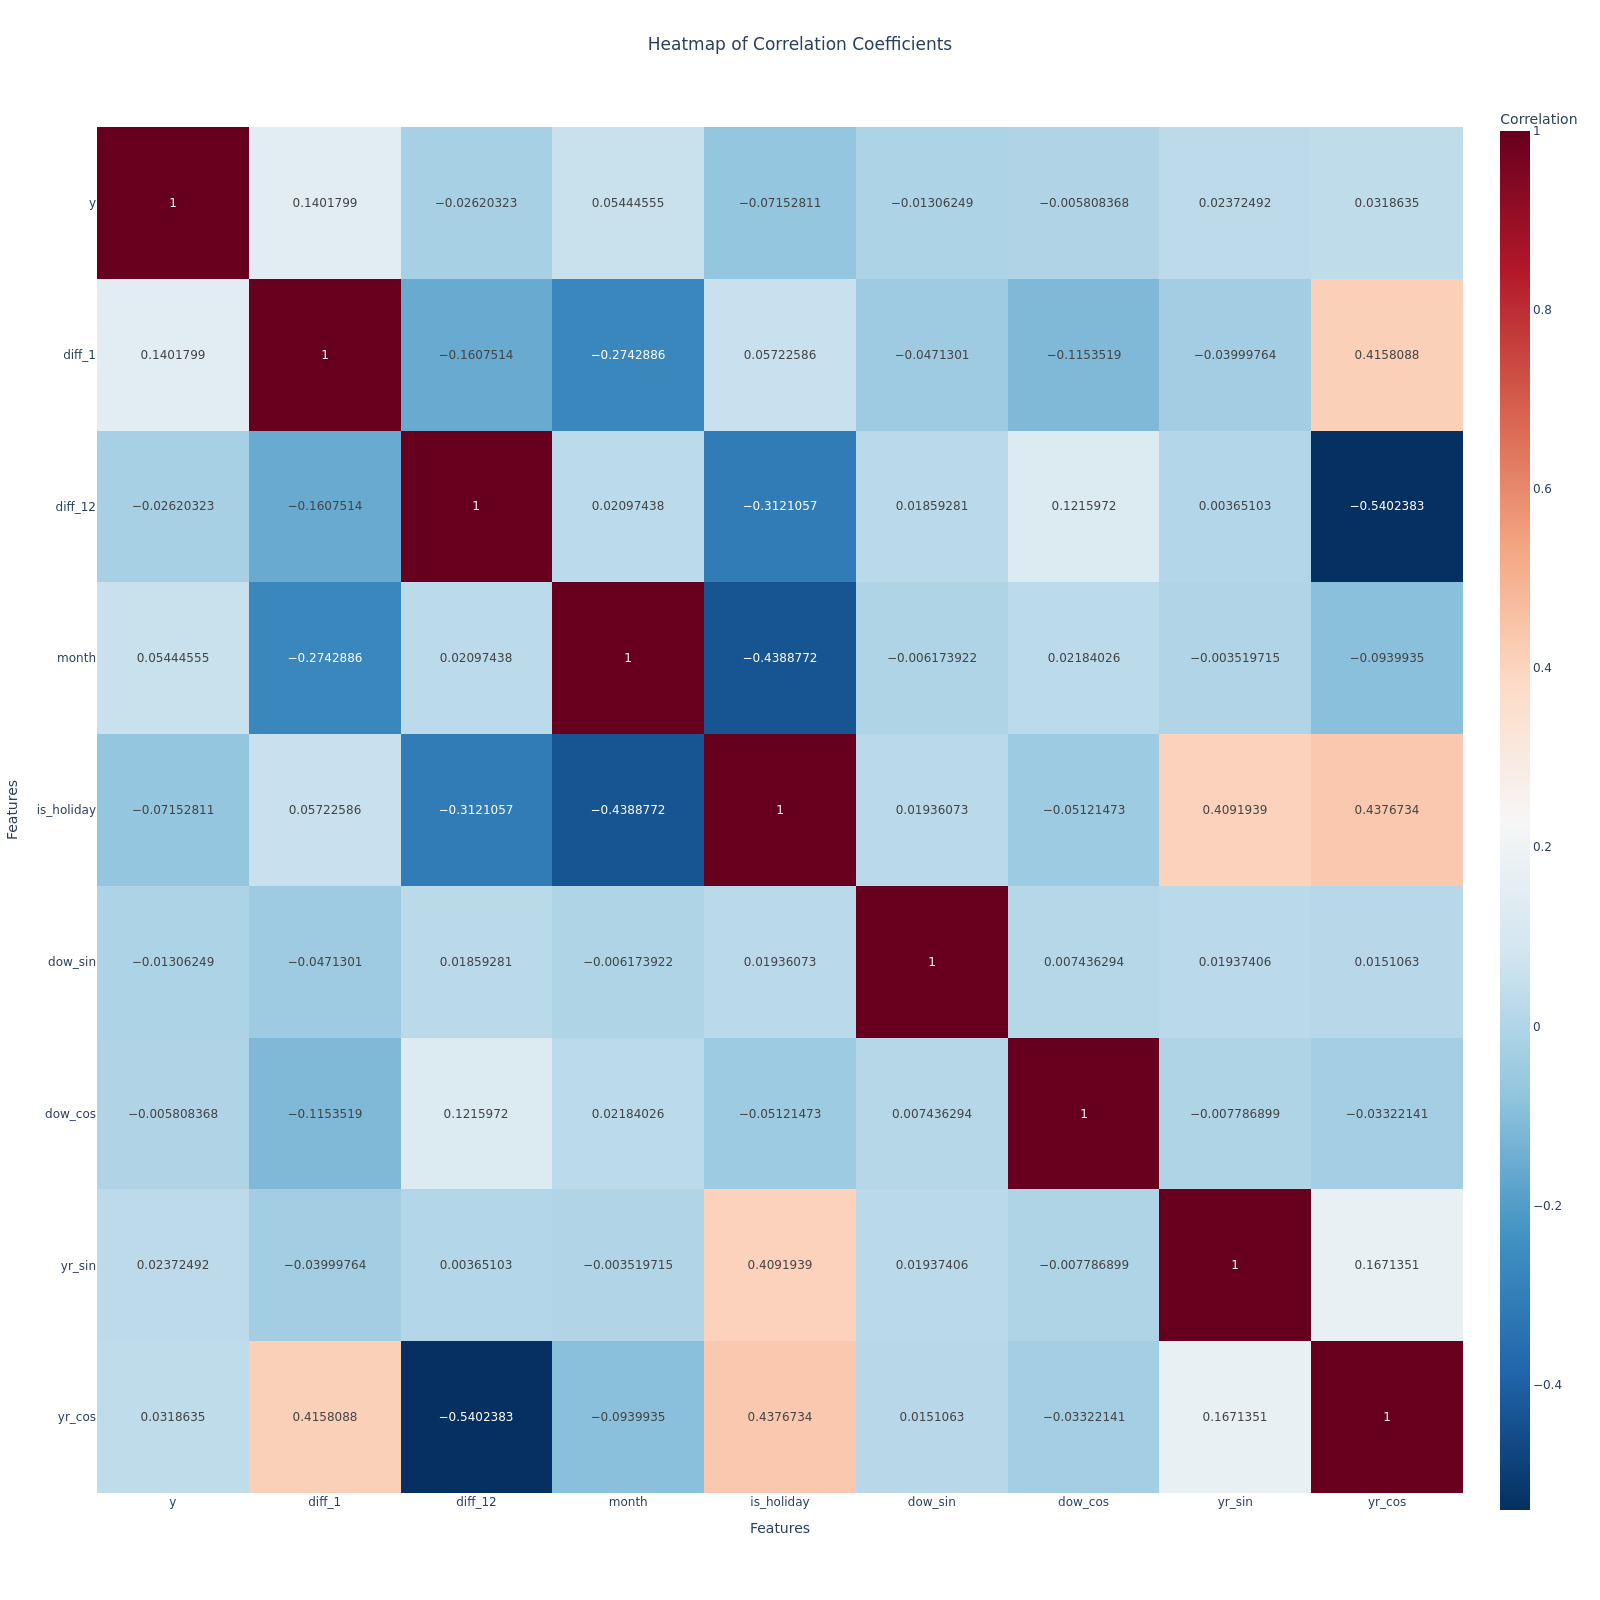

In [573]:
corr_heatmap(df[df.columns[2:]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva